In [1]:
# Static variables
BUCKET='elite-caster-125113'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
spark = SparkSession\
  .builder \
  .appName("Lgistic regression w/ Spark ML") \
  .getOrCreate()

In [32]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from matplotlib import pyplot as plt

## Creating a Training Dataset

In [4]:
# CSV to Dataframe
traindays: DataFrame = spark.read \
  .option("header", "true") \
  .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

In [5]:
traindays.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- is_train_day: string (nullable = true)



In [6]:
# Register the dataframe as TempView for spark sql
traindays.createOrReplaceTempView('traindays')

In [7]:
spark.sql("SELECT * FROM traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2018-01-02|        True|
|2018-01-03|        True|
|2018-01-04|        True|
|2018-01-05|        True|
|2018-01-07|        True|
+----------+------------+



In [8]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,'
header += 'ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,'
header += 'DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,'
header += 'DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,'
header += 'CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,'
header += 'CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,'
header += 'DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,'
header += 'ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

print(header)

def get_structfield(colname: str) -> StructField:
    if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
        return StructField(colname, FloatType(), True)
    else:
        return StructField(colname, StringType(), True)


schema = StructType([get_structfield(colname) for colname in header.split(',')])

FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME


In [9]:
inputs = 'gs://{}/flights/tzcorr/flights-00000-*'.format(BUCKET)
# inputs = 'gs://{}/flights/tzcorr/flights-*'.format(BUCKET)

In [10]:
flights: DataFrame = spark.read \
  .schema(schema) \
  .csv(inputs)
    
flights.createOrReplaceTempView('flights')

23/05/14 13:06:35 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
trainquery: str = """
SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
 t.is_train_day == 'True'
"""

traindata: DataFrame = spark.sql(trainquery)

## Dealing with Corner Cases

In [12]:
traindata.head(2)

[Row(FL_DATE='2018-01-02', OP_UNIQUE_CARRIER='9E', OP_CARRIER_AIRLINE_ID='20363', OP_CARRIER='9E', OP_CARRIER_FL_NUM='3615', ORIGIN_AIRPORT_ID='11898', ORIGIN_AIRPORT_SEQ_ID='1189802', ORIGIN_CITY_MARKET_ID='31898', ORIGIN='GFK', DEST_AIRPORT_ID='13487', DEST_AIRPORT_SEQ_ID='1348702', DEST_CITY_MARKET_ID='31650', DEST='MSP', CRS_DEP_TIME='2018-01-02 19:10:00', DEP_TIME='2018-01-02 19:05:00', DEP_DELAY=-5.0, TAXI_OUT=10.0, WHEELS_OFF='2018-01-02 19:15:00', WHEELS_ON='2018-01-02 20:02:00', TAXI_IN='5.00', CRS_ARR_TIME='2018-01-02 20:29:00', ARR_TIME='2018-01-02 20:07:00', ARR_DELAY=-22.0, CANCELLED='0.00', CANCELLATION_CODE=None, DIVERTED='0.00', DISTANCE=284.0, DEP_AIRPORT_LAT='47.94722222', DEP_AIRPORT_LON='-97.17388889', DEP_AIRPORT_TZOFFSET='-21600.0', ARR_AIRPORT_LAT='44.88194444', ARR_AIRPORT_LON='-93.22166667', ARR_AIRPORT_TZOFFSET='-21600.0', EVENT=None, NOTIFY_TIME=None),
 Row(FL_DATE='2018-01-02', OP_UNIQUE_CARRIER='9E', OP_CARRIER_AIRLINE_ID='20363', OP_CARRIER='9E', OP_CARRIE

In [13]:
traindata[["DEP_DELAY", "TAXI_OUT", "ARR_DELAY", "DISTANCE"]].describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            104732|            104792|           104464|           111534|
|   mean|13.306744834434557|17.099101076418048|6.268293383366519|815.3889576272707|
| stddev| 52.23925364755955| 9.644846467745014|53.40158784227428|605.3003644466102|
|    min|             -49.0|               1.0|            -78.0|             31.0|
|    max|            1752.0|             164.0|           1778.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [14]:
# Revise query by putting NULL fields into account
# Flights that were scheduled but 
#   never left the gate (DEP_DELAY is null)
#   never take off (TAXI_OUT is null) 
# Flights took off but diverted and do not have an ARR_DELAY (This includes TAXI_OUT)
trainquery_revised: str = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
 t.is_train_day == 'True' AND
 f.DEP_DELAY IS NOT NULL AND
 f.ARR_DELAY IS NOT NULL
"""
    
traindata: DataFrame = spark.sql(trainquery_revised)
traindata.describe().show()


+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|            104348|            104348|            104348|           104348|
|   mean|13.169586384022693|17.083997776670373|6.2886686855521905|813.5318261969563|
| stddev| 51.35008338509632|  9.63459230131671|53.425693453588465|602.6741231081046|
|    min|             -49.0|               1.0|             -78.0|             31.0|
|    max|            1752.0|             164.0|            1778.0|           4983.0|
+-------+------------------+------------------+------------------+-----------------+



In [15]:
# I want to fix the root cause instead of fixing the symptom
# See if there are really no NULLs
trainquery_revised_test: str = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
 t.is_train_day == 'True' AND
 f.CANCELLED == '0.00' AND
 f.DIVERTED == '0.00' AND
 (f.DEP_DELAY IS NULL) OR
 (f.ARR_DELAY IS NULL)
"""
    
traindata: DataFrame = spark.sql(trainquery_revised_test)
traindata.head(5)

[Row(DEP_DELAY=None, TAXI_OUT=None, ARR_DELAY=None, DISTANCE=316.0),
 Row(DEP_DELAY=None, TAXI_OUT=None, ARR_DELAY=None, DISTANCE=414.0),
 Row(DEP_DELAY=-11.0, TAXI_OUT=17.0, ARR_DELAY=None, DISTANCE=447.0),
 Row(DEP_DELAY=None, TAXI_OUT=None, ARR_DELAY=None, DISTANCE=316.0),
 Row(DEP_DELAY=None, TAXI_OUT=None, ARR_DELAY=None, DISTANCE=2311.0)]

In [16]:
# Lookds like there still NULLs although we have excluded CACELLED and DIVERTED flights.
# Note: In the book it says that counts will be the same but in my caee it was not so I still needed to exclude the NULLs.
trainquery_revised_final: str = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
 t.is_train_day == 'True' AND
 f.CANCELLED == '0.00' AND
 f.DIVERTED == '0.00' AND
 f.DEP_DELAY IS NOT NULL AND
 f.ARR_DELAY IS NOT NULL
"""
    
traindata: DataFrame = spark.sql(trainquery_revised_final)
traindata.describe().show()


+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|            104348|            104348|            104348|           104348|
|   mean|13.169586384022693|17.083997776670373|6.2886686855521905|813.5318261969563|
| stddev| 51.35008338509632|  9.63459230131671|53.425693453588465|602.6741231081046|
|    min|             -49.0|               1.0|             -78.0|             31.0|
|    max|            1752.0|             164.0|            1778.0|           4983.0|
+-------+------------------+------------------+------------------+-----------------+



## Creating Training Examples

In [17]:
# To use Logistic Regression (https://bit.ly/3HGBYpw)
# I first need labled training sets for binary outcomes.
# In this case , positive lable (1) and negative label(0)
# Note: https://spark.apache.org/docs/3.1.1/mllib-linear-methods.html#loss-functions
# Note that, in the mathematical formulation above, a binary label y is denoted as either +1 (positive) or −1 (negative), 
# which is convenient for the formulation. 
# However, the negative label is represented by 0 in spark.mllib instead of −1, to be consistent with multiclass labeling.
def to_example(raw_data_point: DataFrame) -> LabeledPoint:
    return LabeledPoint(\
            float(raw_data_point['ARR_DELAY'] < 15),  # on-time? \
            [ \
                raw_data_point['DEP_DELAY'], \
                raw_data_point['TAXI_OUT'], \
                raw_data_point['DISTANCE'], \
            ])

examples: DataFrame = traindata.rdd.map(to_example)

## Training

In [18]:
# Creating a model means finding out the weights
# w0*x0 + w1*x1 + w2*x2 + b
lrmodel: LogisticRegressionModel = LogisticRegressionWithLBFGS.train(examples, intercept=True)

23/05/14 13:07:58 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/14 13:07:58 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [19]:
print(lrmodel.weights,lrmodel.intercept)

[-0.15917983474305916,-0.1234567144079457,0.00018240265545446674] 5.553423576407071


In [20]:
lrmodel.predict([6.0, 12.0, 594.0])

1

In [21]:
lrmodel.predict([36.0, 12.0, 594.0])

0

In [22]:
lrmodel.clearThreshold()

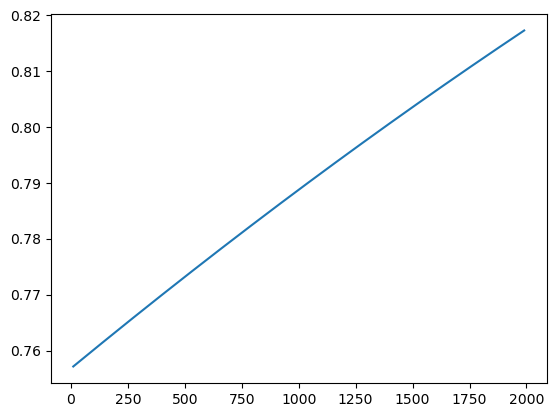

In [33]:
# Predict probability with fixed dep delay and taxi-out
dist: np.ndarray = np.arange(10, 2000, 10)
prob: list = [lrmodel.predict([20,10,d]) for d in dist]
plt.plot(dist, prob)

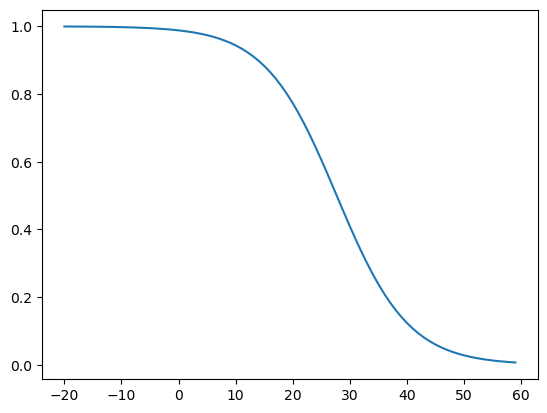

In [35]:
# Predict probability with fixed taxi-out  and distance
delay: np.ndarray = np.arange(-20, 60, 1)
prob= list = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)

In [ ]:
lrmodel.setThreshold(0.7)